In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, urllib, itertools, shutil, random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
import PIL

In [2]:
path_to_folder = '/Users/argosaakan/Data/porto' # Указать свой путь к папке с csv файлами
os.chdir(path_to_folder)

In [3]:
# Функция для обрисовки матрицы сопряжения
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Функция для преобразования ссылки в изображение
def url_jpg(URL_PATH, IMAGE_PATH):
    URLS = pd.read_csv(URL_PATH)
    url = []
    for i in enumerate(URLS.values):
        links = i[1][0]
        url.append(links)

    for j in range(len(url)):
        fileName = ('image{}.jpg'.format(j))
        imagePath = (os.path.join(IMAGE_PATH, fileName))
        urllib.request.urlretrieve(url[j], imagePath)

In [5]:
# Убедимся, что папки не существуют и скачаем изоюражения, разложим по папкам
gev_file_path = os.path.join(path_to_folder, 'georges.csv')
not_gev_file_path = os.path.join(path_to_folder, 'non_georges.csv')

gev_images_path = os.path.join(path_to_folder, 'gevs')
not_gev_images_path = os.path.join(path_to_folder, 'not_gevs')

if os.path.isdir('gevs') is False and os.path.isdir('train') is False:
    os.mkdir(gev_images_path)
    url_jpg(gev_file_path, gev_images_path)
    
    os.mkdir(not_gev_images_path)
    url_jpg(not_gev_file_path, not_gev_images_path)

In [6]:
# Разделим изображения на train, valid и test, разложим по папкам (Георгии и неГеоргии отдельно в каждой папке)
random.seed(0)
if os.path.isdir('train') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for name in ['gevs', 'not_gevs']:
        shutil.move(f'{name}', 'train')
        os.mkdir(f'valid/{name}')
        os.mkdir(f'test/{name}')

        valid_samples = random.sample(os.listdir(f'train/{name}'), 600)
        for j in valid_samples:
            shutil.move(f'train/{name}/{j}', f'valid/{name}')
        
        test_samples = random.sample(os.listdir(f'train/{name}'), 100)
        for k in test_samples:
            shutil.move(f'train/{name}/{k}', f'test/{name}')
os.chdir('../..')

In [7]:
# Создадим генераторы train, valid и test и предпобработаем изображения для mobilenet
train_path = os.path.join(path_to_folder, 'train')
valid_path = os.path.join(path_to_folder, 'valid')
test_path = os.path.join(path_to_folder, 'test')

train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['gevs', 'not_gevs'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['gevs', 'not_gevs'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['gevs', 'not_gevs'], batch_size=10, shuffle=False)

Found 4645 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [8]:
# Загрузим предобученную модель
mobile_net = keras.applications.MobileNet()

In [9]:
# Посмотрим на предобученную модель, выберем какие из последних слоев будем заменять
mobile_net.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

In [10]:
# Оставим все слои кроме последних пяти. 
# Добавим выходной слой с активационной функцией softmax для определения класса
x = mobile_net.layers[-6].output
output = Dense(2, activation='softmax')(x)

model = Model(inputs=mobile_net.input, outputs=output)

In [11]:
# При обучении будем работать с весами последних 23 слоев
for layer in model.layers[:-23]:
    layer.trainable = False

In [12]:
# Определим раннюю остановку обучения, компилируем модель
early_stopping = keras.callbacks.EarlyStopping(
    patience=2,
    min_delta=0.001,
    restore_best_weights=True,
)

model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Обучаем модель
history = model.fit(
    x=train_batches, 
    validation_data=valid_batches, 
    epochs=6, 
    callbacks=[early_stopping]
)

Epoch 1/6
465/465 [==============================] - 165s 351ms/step - loss: 0.5347 - accuracy: 0.7929 - val_loss: 0.4352 - val_accuracy: 0.8383
Epoch 2/6
465/465 [==============================] - 164s 353ms/step - loss: 0.2005 - accuracy: 0.9208 - val_loss: 0.2618 - val_accuracy: 0.9075
Epoch 3/6
465/465 [==============================] - 169s 363ms/step - loss: 0.1490 - accuracy: 0.9507 - val_loss: 0.2764 - val_accuracy: 0.9117
Epoch 4/6
465/465 [==============================] - 168s 360ms/step - loss: 0.1032 - accuracy: 0.9641 - val_loss: 0.3350 - val_accuracy: 0.8933


<AxesSubplot:title={'center':'Cross-entropy'}>

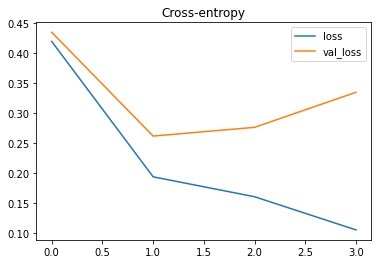

In [14]:
# Посмотрим на график функции потерь (на train и valid). Хочется минимизировать val loss, 
# при этом не переобучить модель на train set. 
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")

In [15]:
# Проверяем accuracy на изображениях, которые модель ранее не видела
scores = model.evaluate(test_batches)
print(f'Accuracy: {round((scores[1]*100), 2)}%')

20/20 [==============================] - 4s 215ms/step - loss: 0.2054 - accuracy: 0.9100
Accuracy: 91.0%


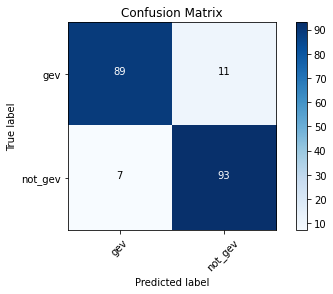

In [16]:
# Строим матрицу сопряженности
preds = model.predict(test_batches)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(preds, axis=1))
plot_confusion_matrix(cm=cm, classes=['gev','not_gev'], title='Confusion Matrix')

Как видим, модели удается правильно классифицировать изображения в более 90% случаев. Точность на обучающем сете (92%) практически не отличается от точности на валидацинном(90%) и тестовом (91%) сетах, значит модель не переобучена, что хорошо.

Модель правильно идентифицировала Георгия в 89% случаев и правильно определила его отсутствие в 93%. В задачах, требующих максимизации True Positives, следует поработать с весами классов. Это поможет найти больше Григориев, при этом, "ложных Григориев" тоже станет больше.

В следующей ячейке кода показаны примеры изображений из тестового сета с классификацией модели. Нужно раскомментировать, чтобы посмотреть.

In [17]:
# preds_catigorical = pd.Series(np.argmax(preds, axis=1)).replace({0: 'Gev', 1: 'not Gev'})

# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=[16, 8])
# ind = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]

# for i, axi in enumerate(ax.flat):
#     image = PIL.Image.open(test_batches.filepaths[ind[i]])
#     axi.imshow(image)
#     axi.set_title(preds_catigorical[ind[i]])
#     axi.axis('off')
#     plt.tight_layout()

# plt.show()

In [18]:
# Ряд факторов влияют на то, что от раза к разу модель выдает разные результаты. 
# Самым правильным решением будет сохранение модели после подбора оптимальных параметров

# model.save('path/to/location')

### Спасибо за внимание!